# Trial by trial fit of InSpe data for searchlight classificiation
This tutorial will load models and data from tutorial 15 and change the design matrix to one that gives a beta estimate for each trial.
It then conducts a searchlight classification analysis and finds the best performing voxels.
Lastly, it conducts a permutation test on a test data set, selecting the best voxels.

## NB. The searchlight analysis takes a long time to run and uses a lot of memory.
If you want to use this script, please consider:
- converting to .py and running using tmux (see `xx_tmux_notes.ipynb`)
- using a machine with more RAM (48GB?)
- being patient (will take at least 10 hours).

In [21]:
#Convert notebook ot .py for running from terminal
!jupyter nbconvert --to python /work/807746/marcs_folder/notebooks/16_Nilearn_InSpe_classification_single_sub.ipynb

[NbConvertApp] Converting notebook /work/807746/marcs_folder/notebooks/16_Nilearn_InSpe_classification_single_sub.ipynb to python
[NbConvertApp] Writing 20369 bytes to /work/807746/marcs_folder/notebooks/16_Nilearn_InSpe_classification_single_sub.py


<div class="alert alert-success" role="alert">

# Preamble: Activate environment
In the first notebook, we installed a python environment. If you haven't don so, please go back to the ```01_setup_virtual_environment.ipynb``` and complete this before proceeding.

If you closed/stopped the UCloud run between then and now, we will need to reactivate the environment.

For this we use a bash script with a subset of the lines we used for setting up the environment

The script called ```activate.sh``` This should be located in your working directory. If not, save the following in a file with this filename.

```bash
. /work/<MY DIRECTORY NUMBER>/virt_env/bin/activate
python -m ipykernel install --user --name=virt_env
echo Done! Remember changing the kernel in Jupyter.
```
</div>

In [2]:
import os
path='/work/807746/marcs_folder/notebooks' # Remember to change this to your own path
os.chdir(path)
!./activate.sh


Installed kernelspec virt_env in /home/ucloud/.local/share/jupyter/kernels/virt_env
Done! Remember changing the kernel in Jupyter.


<div class="alert alert-success" role="alert">
    
### Check that we are in the right environment

</div>

In [22]:
import sys
print(sys.executable)
#Check that we have something installed.
import nilearn
import os

/work/807746/marcs_folder/notebooks/virt_env/bin/python


In [5]:
# Additional imports
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import pandas as pd

#### Importing data and models from tutorial 15
The data in tutorial 15 were analysed to not include the self/other distinction. If you want to study that, you need to edit the event names.

In [6]:
import pickle

now = datetime.now()
print('Starting cell:',now.strftime("%H:%M:%S"))

f = open('/work/807746/marcs_folder/InSpe_first_level_models.pkl', 'rb')
models, models_run_imgs, models_events, models_confounds = pickle.load(f)
f.close()



now = datetime.now()
print('Loaded models:',now.strftime("%H:%M:%S"))

Starting cell: 18:27:28
Loaded models: 18:27:29


### Figuring out what is in the models_events variable

In [7]:
# Inspect number of scans and confounds included in the first participant, first run:
print(models_confounds[6][0].shape)
# Inspect number of trials, onsets and trial types for the first participant, first run:
print(models_events[6][0])


(490, 22)
         onset  duration trial_type
0     1.010745  0.685782          N
1     6.313775  0.700187          N
2    12.630463  0.700153          B
3    16.947486  0.699789          B
4    23.264478  0.700142          N
..         ...       ...        ...
85  454.935872  0.700018          B
86  461.252978  0.699931          P
87  465.569811  0.699926          P
88  469.886653  0.700122          B
89  474.203819  0.699610          N

[90 rows x 3 columns]


## Creating new design matrices with a column per experimental trial.

In [8]:
import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix
import numpy as np
lsa_dm=[]

# Changing the model for a single participant (0117):
for ii in range(len(models_events[6])):
    # Sort onsets by trial type to make later processing easier
    #models_events[0][ii].sort_values(by=['trial_type'], inplace=True)
     #N=number of events
    N=models_events[6][ii].shape[0]
    # time frame with 490 scans with 1s TR:
    t_fmri = np.linspace(0, 490,490,endpoint=False)
    # We have to create a dataframe with onsets/durations/trial_types
    # No need for modulation!
    trials = pd.DataFrame(models_events[6][ii], columns=['onset'])
    trials.loc[:, 'duration'] = 0.7
    trials.loc[:, 'trial_type'] = [models_events[6][ii]['trial_type'][i-1]+'_'+'t_'+str(i).zfill(3)  for i in range(1, N+1)]

    # lsa_dm = least squares all design matrix
    lsa_dm.append(make_first_level_design_matrix(
        frame_times=t_fmri,  # we defined this earlier 
        events=trials,
        add_regs=models_confounds[6][ii], #Add the confounds from fmriprep
        hrf_model='glover',
        drift_model='cosine'  
    ))
    




now = datetime.now()
print('Finish making single trial models:',now.strftime("%H:%M:%S"))

/work/807746/marcs_folder/notebooks/virt_env/lib/python3.10/site-packages/nilearn/glm/_utils.py:319: UserWarning: Matrix is singular at working precision, regularizing...
  warn("Matrix is singular at working precision, regularizing...")


Finish making single trial models: 18:27:55


### Check out the created design matrix
Note that the index represents the frame times

In [37]:
print(lsa_dm[0])

            B_t_003       B_t_004       B_t_006       B_t_007       B_t_008  \
0.0   -1.248977e-08 -9.005734e-09 -1.051333e-08 -5.654167e-09 -3.542154e-09   
1.0   -1.245812e-08 -8.992370e-09 -1.052729e-08 -5.674765e-09 -3.580534e-09   
2.0   -1.099136e-08 -7.983892e-09 -1.015201e-08 -4.923472e-09 -2.571521e-09   
3.0   -9.396168e-09 -6.697634e-09 -8.656764e-09 -5.076316e-09 -3.216773e-09   
4.0   -6.937301e-09 -6.470584e-10 -5.488215e-09 -3.368061e-09 -4.170476e-10   
...             ...           ...           ...           ...           ...   
485.0  1.422910e-09  6.703575e-09 -1.013878e-11 -1.994640e-10 -7.138276e-10   
486.0  2.362728e-09  9.692502e-09  5.275065e-10 -3.965351e-10  7.428325e-10   
487.0  4.408799e-10  5.920072e-09 -1.414332e-09 -1.291853e-09 -1.346295e-09   
488.0  4.534484e-09  7.921702e-09  5.176222e-10  2.582744e-10 -9.799872e-10   
489.0  4.964654e-09  1.017799e-08  1.361728e-09  9.746146e-10  8.150489e-10   

            B_t_011       B_t_013       B_t_016    

## Plot the new design matrices

Finishing cell: 18:28:03


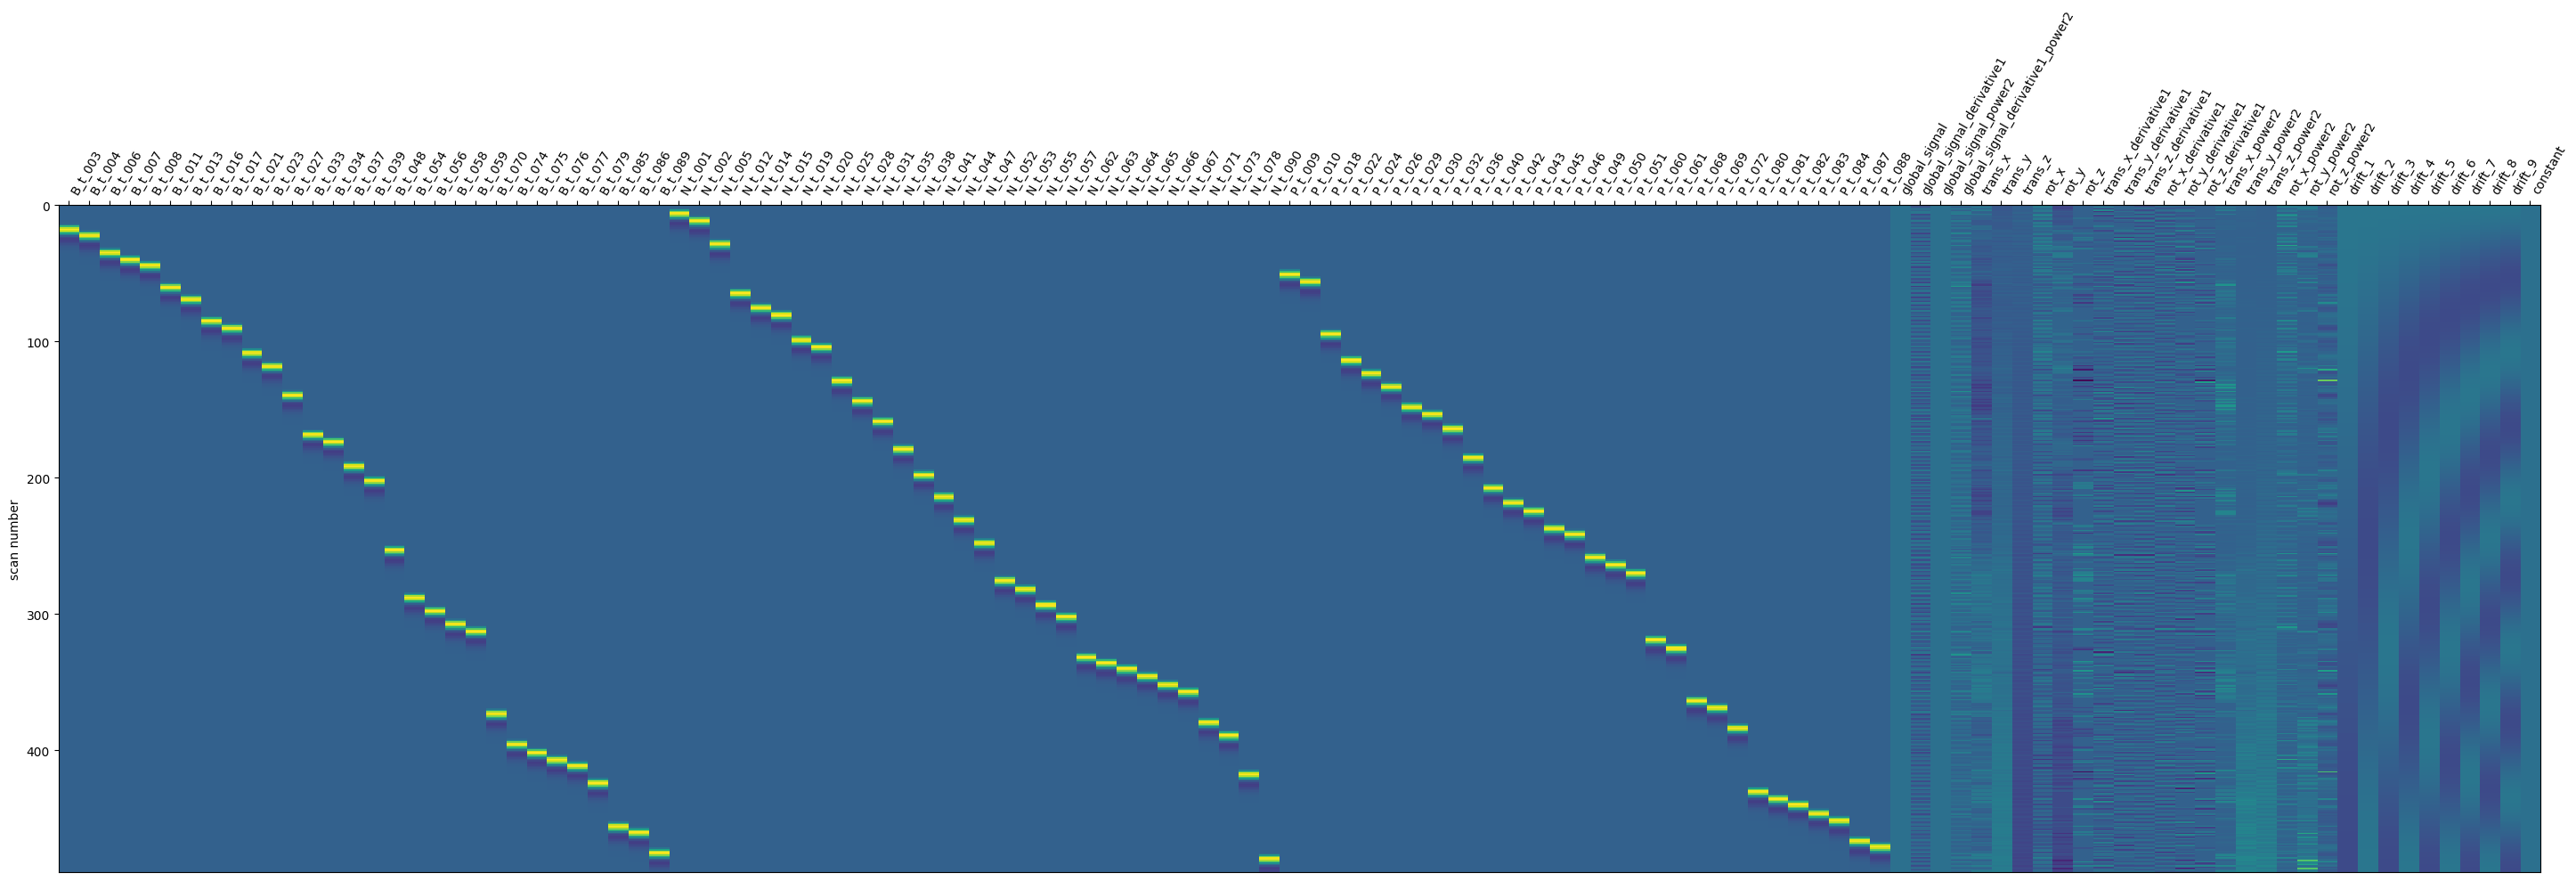

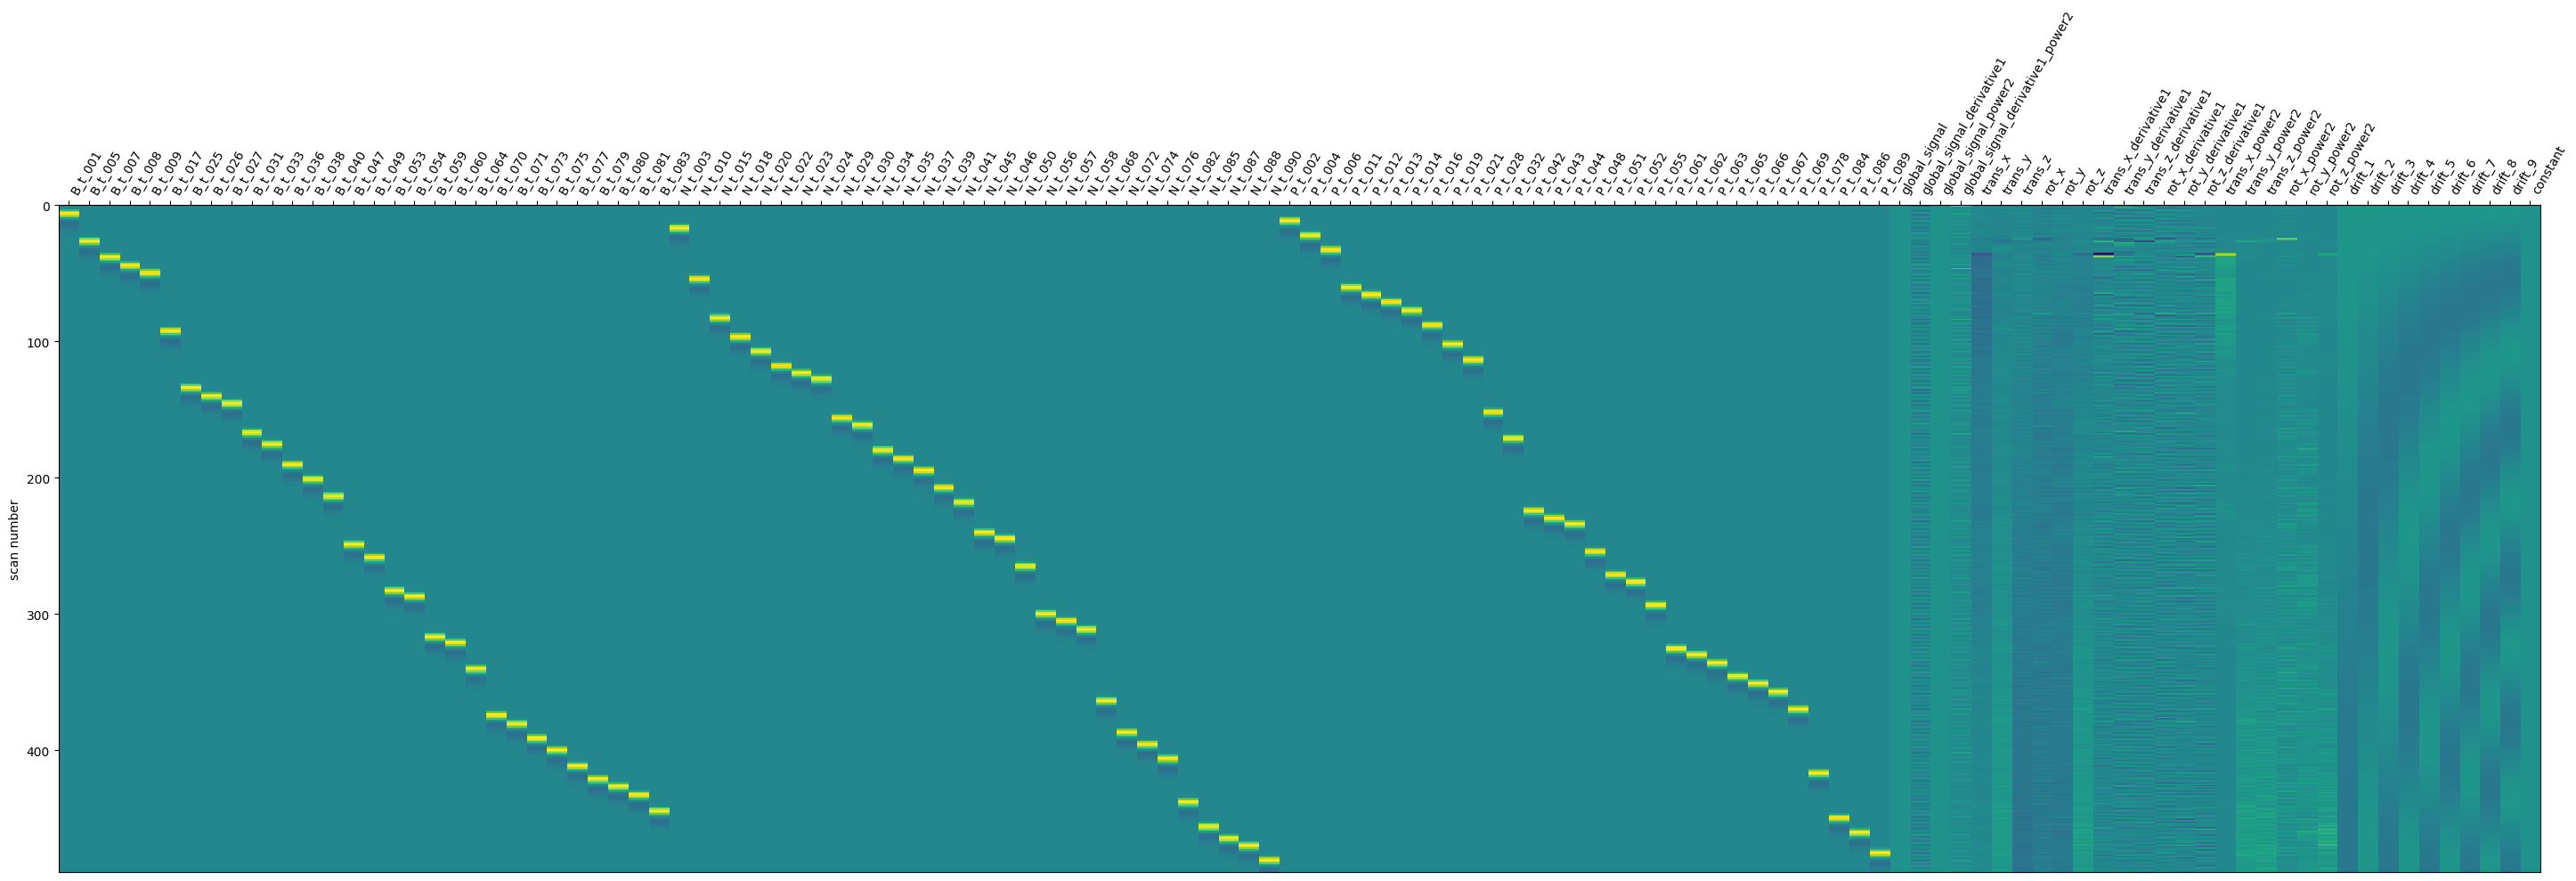

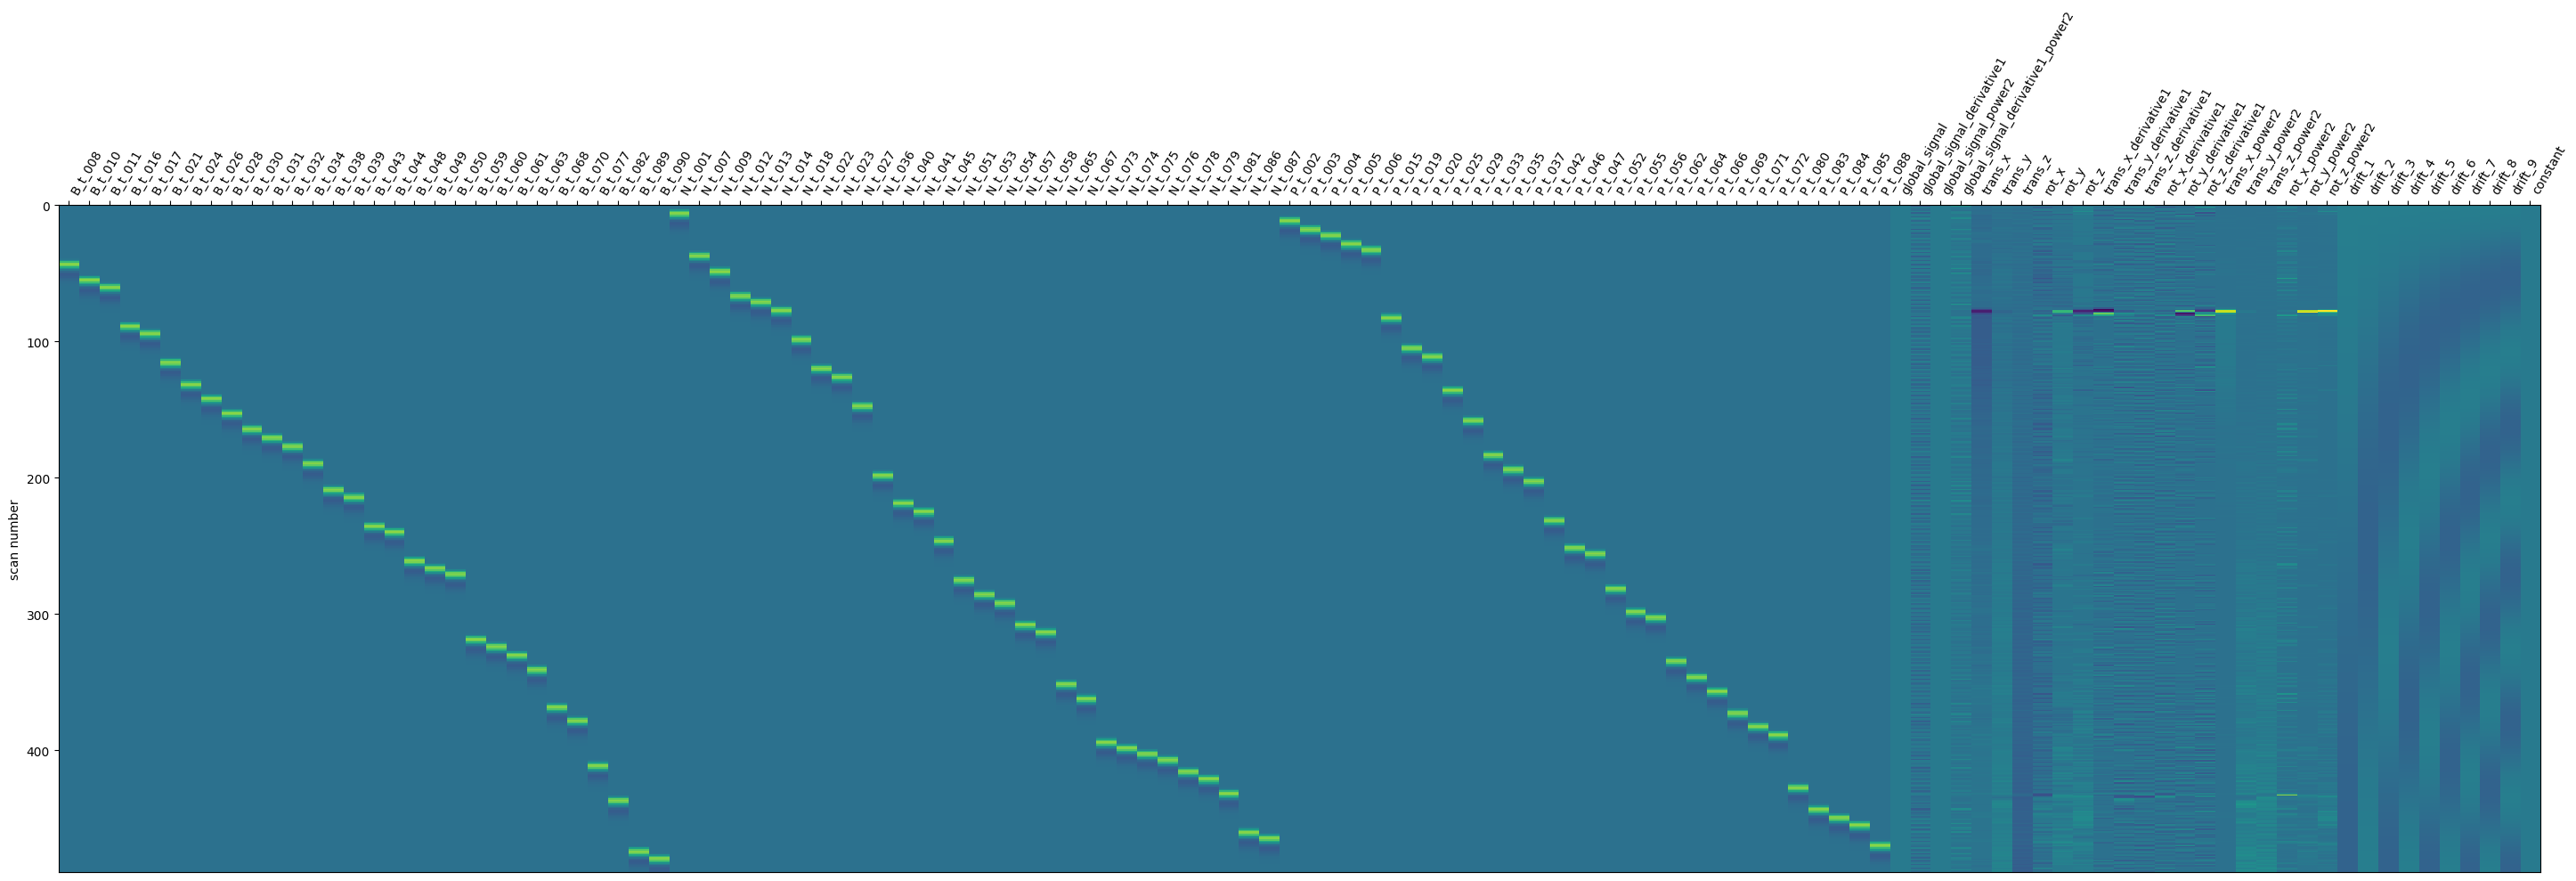

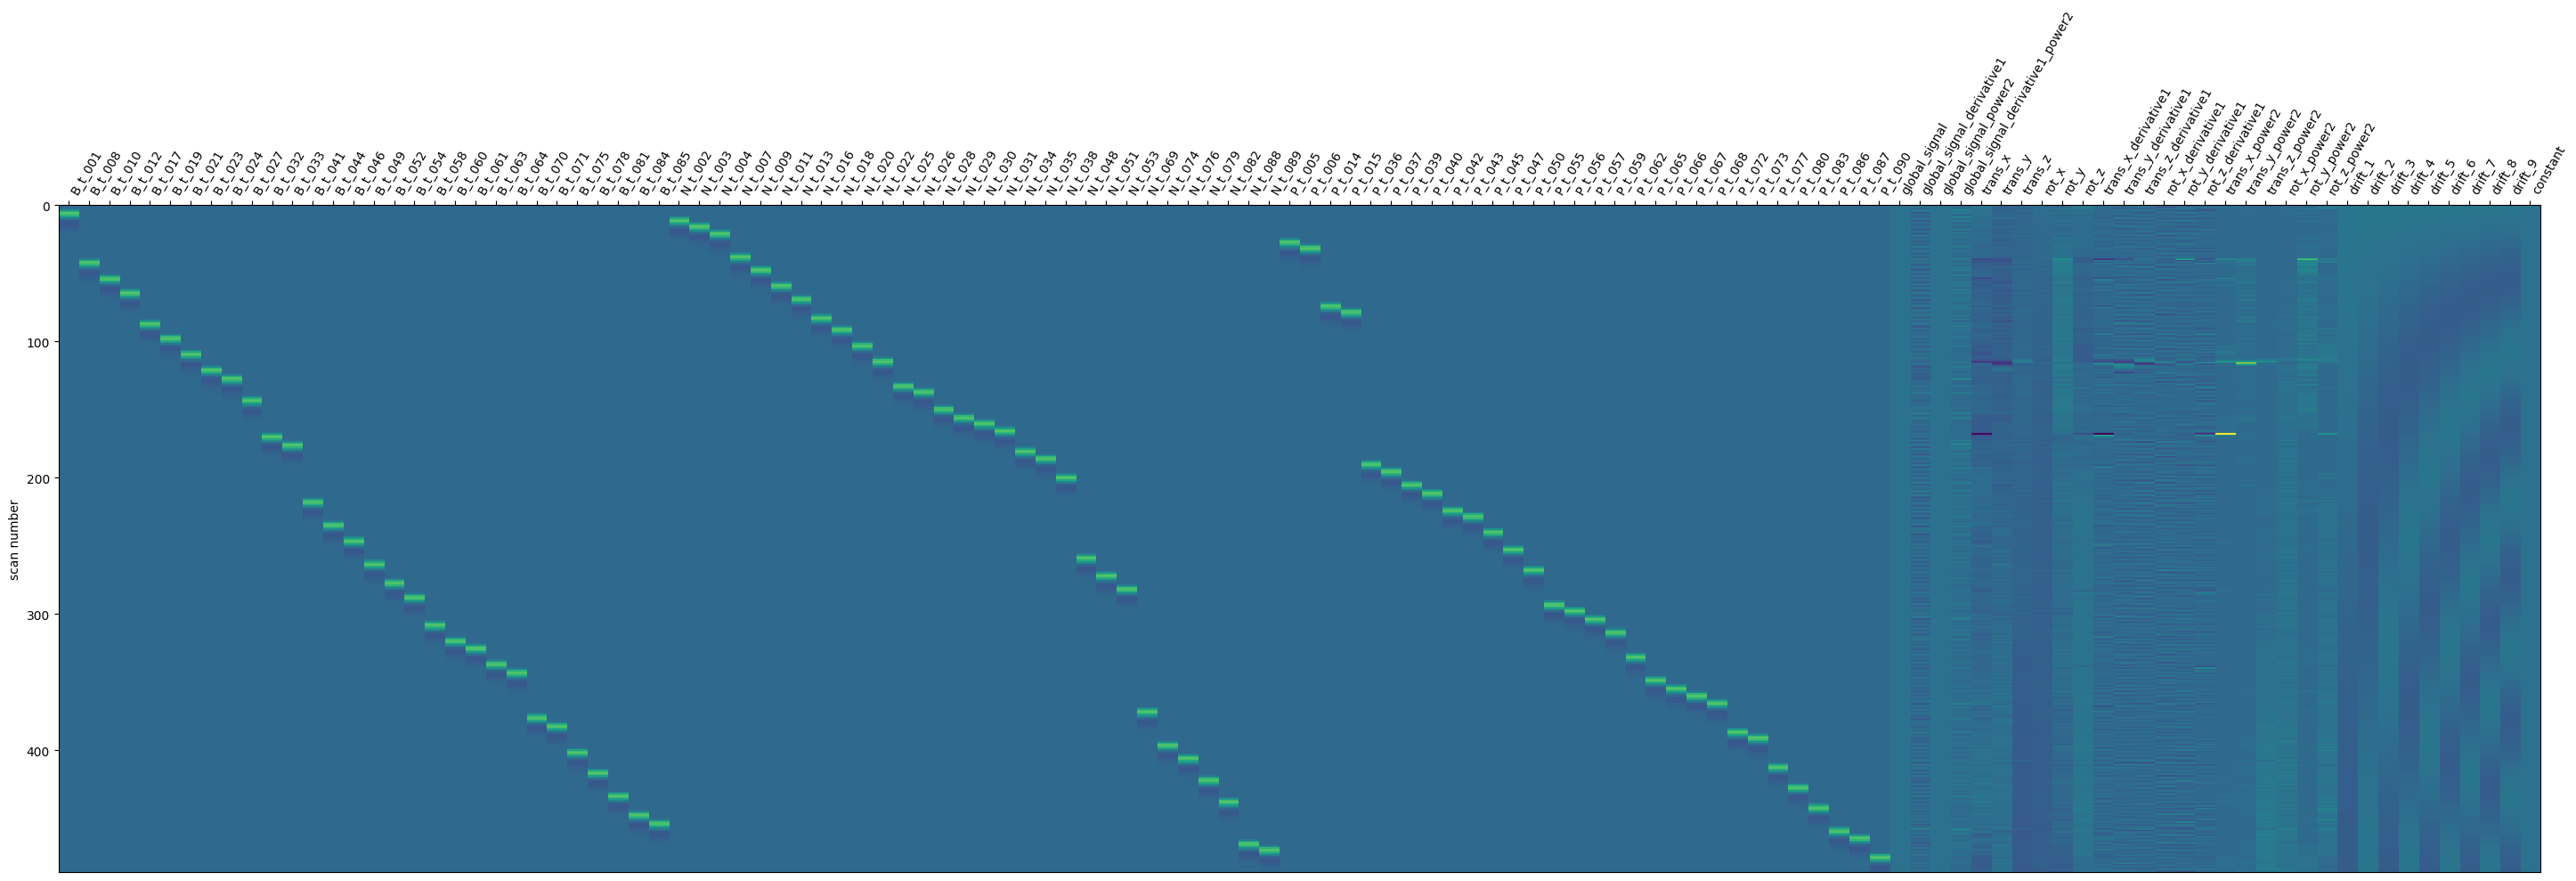

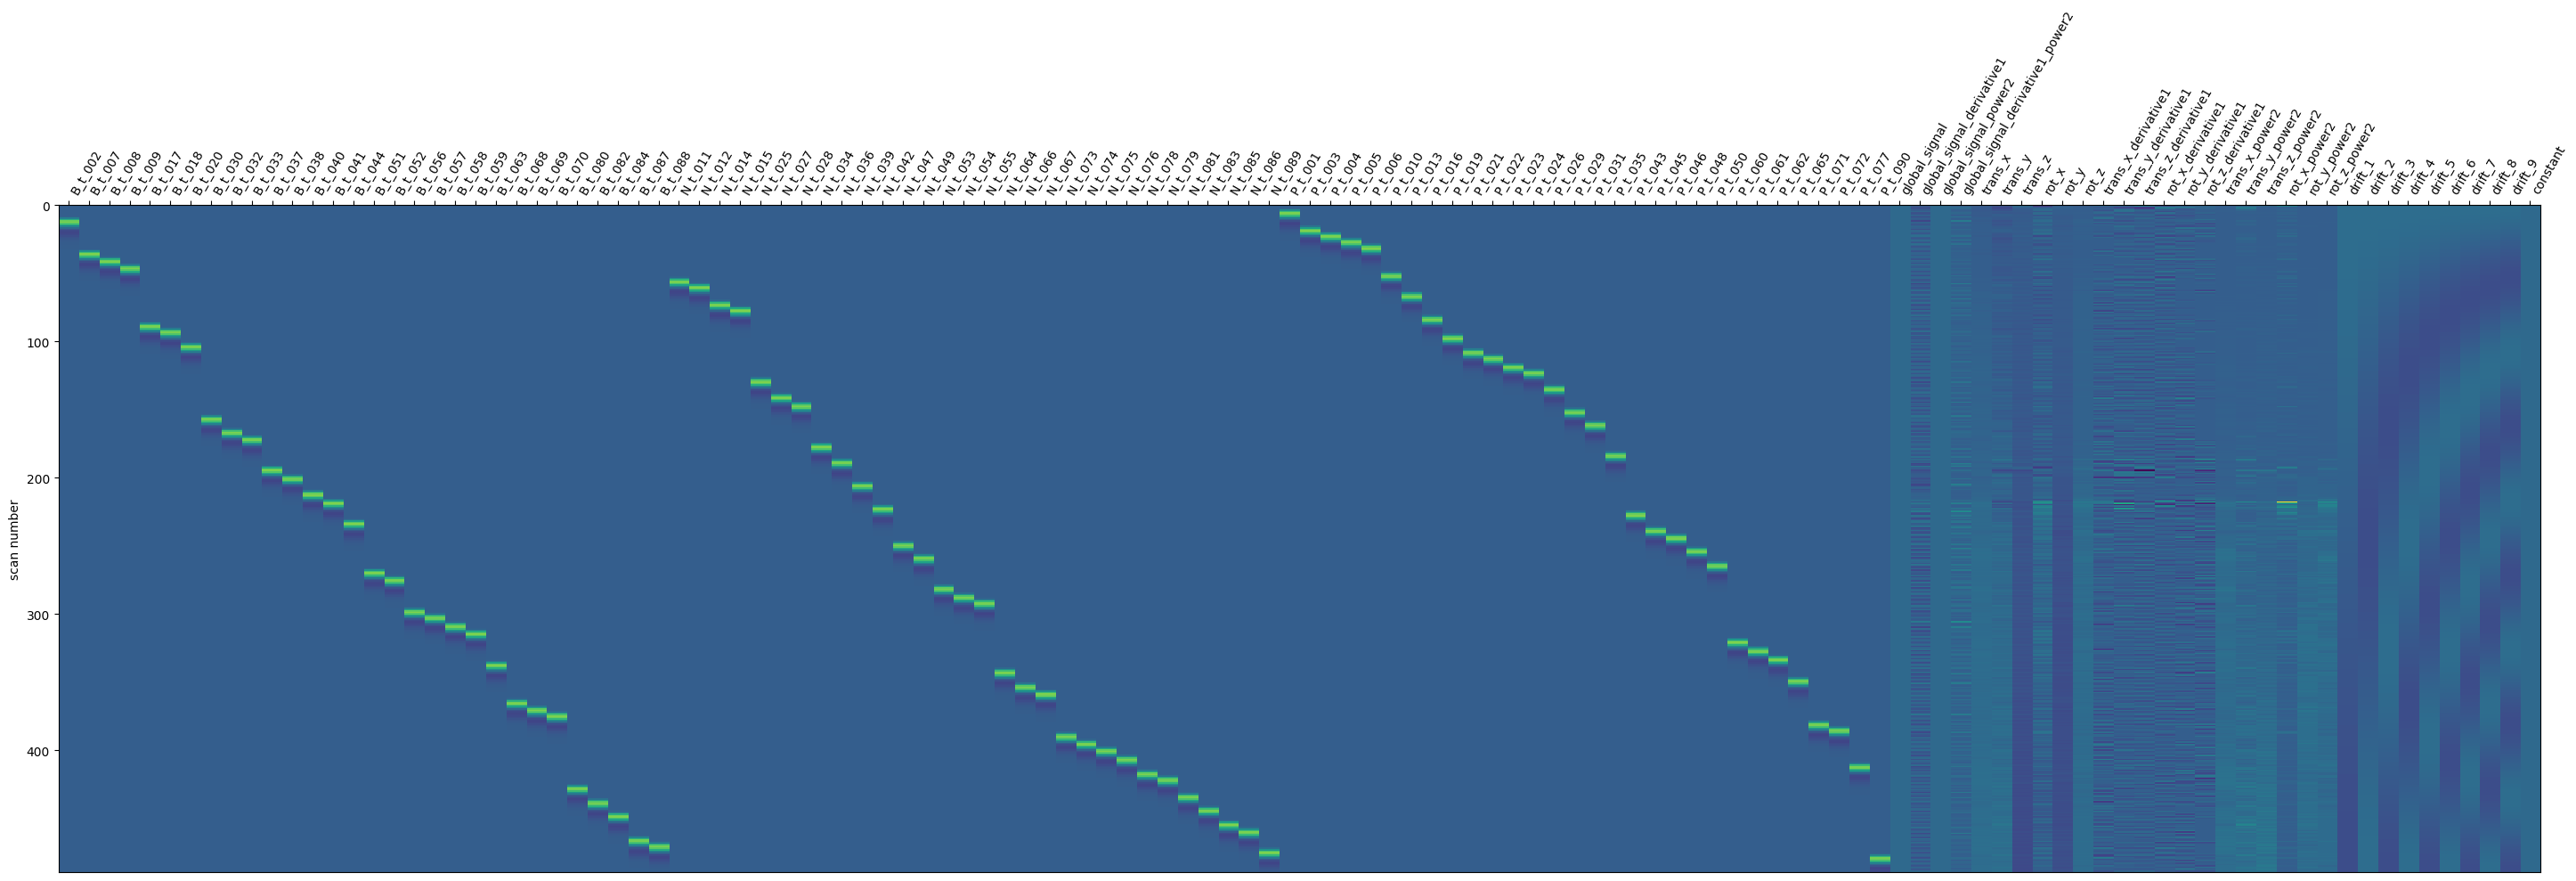

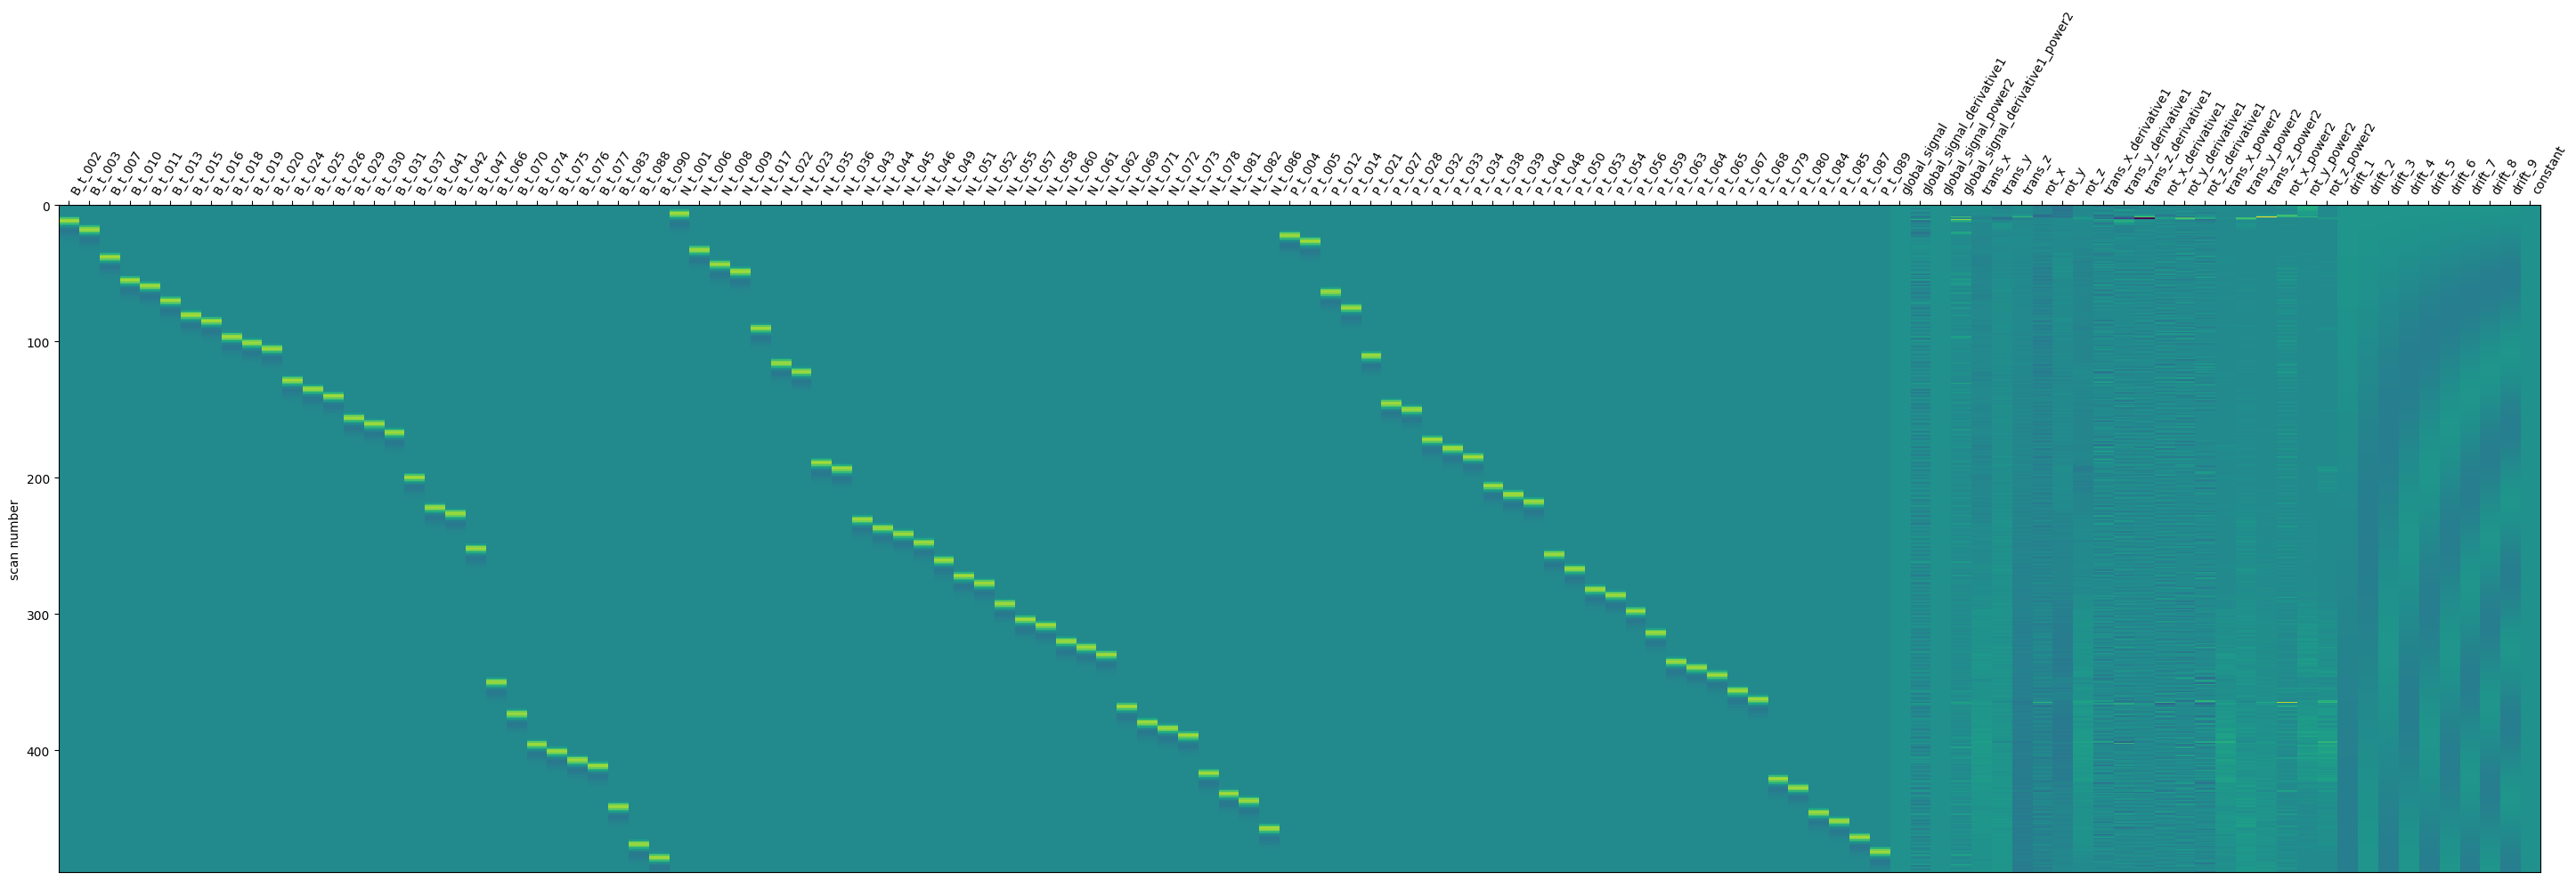

In [9]:
from nilearn.plotting import plot_design_matrix
for ii in range(len(models_events[6])):
    plot_design_matrix(lsa_dm[ii]);

now = datetime.now()
print('Finishing cell:',now.strftime("%H:%M:%S"))

### Let's inspect the correlational structure of the design matrix

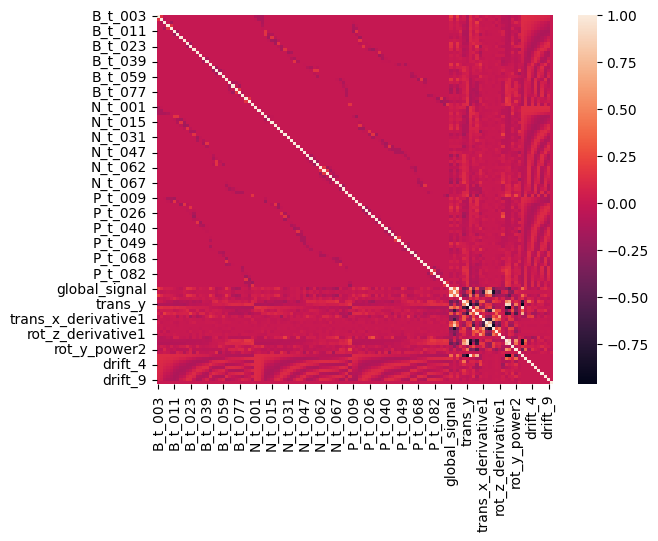

In [41]:
import seaborn as sns
dm_corr=lsa_dm[0].corr()
p1 = sns.heatmap(dm_corr)

## Fit the models for all sessions from one participant

In [42]:
print(models_events)

[[         onset  duration trial_type
0     1.011768  0.687413          N
1     7.316153  0.699797          B
2    13.633416  0.699553          P
3    19.950277  0.699941          B
4    25.267011  0.700103          P
..         ...       ...        ...
85  451.938302  0.700011          P
86  458.255509  0.699893          B
87  462.572407  0.699936          B
88  468.889057  0.699817          N
89  475.206026  0.699949          N

[90 rows x 3 columns],          onset  duration trial_type
0     0.992516  0.682951          P
1     7.292325  0.700086          B
2    11.608899  0.700067          P
3    17.925897  0.700268          N
4    22.242960  0.700022          N
..         ...       ...        ...
85  455.914824  0.699454          N
86  462.231561  0.699931          P
87  466.548594  0.699581          B
88  470.865277  0.700020          P
89  475.182019  0.699961          B

[90 rows x 3 columns],          onset  duration trial_type
0     0.992944  0.680293          B
1     7.290811

In [43]:

from nilearn.glm.first_level import FirstLevelModel

model1=[]
for ii in range(len(models_events[6])):
    
    # Get data and model info for 1st participant, 1st session
    imgs1=models_run_imgs[6][ii]
    model1.append (FirstLevelModel())
    #Fit the model
    print('Fitting GLM: ', ii+1)
    model1[ii].fit(imgs1,design_matrices=lsa_dm[ii])

now = datetime.now()
print('Finishing model fit:',now.strftime("%H:%M:%S"))

Fitting GLM:  1
Fitting GLM:  2
Fitting GLM:  3
Fitting GLM:  4
Fitting GLM:  5
Fitting GLM:  6
Finishing model fit: 20:27:38


## Saving/retrieving the fitted models and design matrices

In [45]:
import pickle

# Saving the objects:
f = open('/work/807746/marcs_folder/InSpe_first_level_models_all_trials.pkl', 'wb')
pickle.dump([model1, lsa_dm], f)
f.close()

## Getting back the objects:
f = open('/work/807746/marcs_folder/InSpe_first_level_models_all_trials.pkl', 'rb')
model1, lsa_dm = pickle.load(f)
f.close()

#print(model1[0])
now = datetime.now()
print('Saved model and design matrices:',now.strftime("%H:%M:%S"))

Saved model and design matrices: 20:31:36


## Making beta map contrasts from the fitted model to use in later analyses

In [46]:
now = datetime.now()
print('Computing contrasts:',now.strftime("%H:%M:%S"))
b_maps = []
conditions_label = []

for ii in range(len(models_events[6])):
    N=models_events[6][ii].shape[0]
    #Make an identity matrix with N= number of trials
    contrasts=np.eye(N)
    #print(contrasts.shape)
    #Find difference between columns in design matrix and number of trials
    dif=lsa_dm[ii].shape[1]-contrasts.shape[1]
    #print(dif)
    #Pad with zeros
    contrasts=np.pad(contrasts, ((0,0),(0,dif)),'constant')
    #print(contrasts.shape)
    print('Making contrasts for session : ', ii+1)
    print('Number of contrasts : ', N)
    for i in range(N):
        #Add a beta-contrast image from each trial
        b_maps.append(model1[ii].compute_contrast(contrasts[i,], output_type='effect_size'))
        # Make a variable with condition labels for use in later classification
        conditions_label.append(lsa_dm[ii].columns[i])
#        session_label.append(session)

now = datetime.now()
print('Done computing contrasts:',now.strftime("%H:%M:%S"))


Computing contrasts: 20:32:51
Making contrasts for session :  1
Number of contrasts :  90
Making contrasts for session :  2
Number of contrasts :  90
Making contrasts for session :  3
Number of contrasts :  90
Making contrasts for session :  4
Number of contrasts :  90
Making contrasts for session :  5
Number of contrasts :  90
Making contrasts for session :  6
Number of contrasts :  90
Done computing contrasts: 21:01:53


## Saving models and beta maps

In [47]:
import pickle

#Save the first level models

# Saving the objects:
f = open('/work/807746/marcs_folder/InSpe_first_level_models_all_trials.pkl', 'wb')
pickle.dump([model1, lsa_dm, conditions_label, b_maps], f)
f.close()

# Getting back the objects:
f = open('/work/807746/marcs_folder/InSpe_first_level_models_all_trials.pkl', 'rb')
model1, lsa_dm, conditions_label, b_maps = pickle.load(f)
f.close()

now = datetime.now()
print('Saved beta-maps:',now.strftime("%H:%M:%S"))

del model1

Saved beta-maps: 21:02:24


## Reshape data for classification
Checking that the design matrix and the condition labels look the same.

In [48]:
print('Checking that column names for design matrix matches labels')
print(lsa_dm[0].columns[0:9])
print(conditions_label[0:9])

Checking that column names for design matrix matches labels
Index(['B_t_003', 'B_t_004', 'B_t_006', 'B_t_007', 'B_t_008', 'B_t_011',
       'B_t_013', 'B_t_016', 'B_t_017'],
      dtype='object')
['B_t_003', 'B_t_004', 'B_t_006', 'B_t_007', 'B_t_008', 'B_t_011', 'B_t_013', 'B_t_016', 'B_t_017']


Selecting Positive and negative trials

In [49]:

now = datetime.now()
print('Renaming labels to N, P, and B:',now.strftime("%H:%M:%S"))

f = open('/work/807746/marcs_folder/InSpe_first_level_models_all_trials.pkl', 'rb')
model1, lsa_dm, conditions_label, b_maps = pickle.load(f)
f.close()

import numpy as np
#from nilearn import datasets
from nilearn.image import new_img_like, load_img, index_img, clean_img, concat_imgs
from sklearn.model_selection import train_test_split, GroupKFold
n_trials=len(conditions_label)
#print(n_trials)

#Concatenate beta maps
b_maps_conc=concat_imgs(b_maps)
#print(b_maps_conc.shape)
del b_maps
# Reshaping data------------------------------
from nilearn.image import index_img, concat_imgs



#Find all negative and positive trials
idx_neg=[int(i) for i in range(n_trials) if 'N_' in conditions_label[i]]
idx_pos=[int(i) for i in range(n_trials) if 'P_' in conditions_label[i]]
idx_but=[int(i) for i in range(n_trials) if 'B_' in conditions_label[i]]


##Make an index for self/other sessions #
#def intersection(list_a, list_b):
#    return [ e for e in list_a if e in list_b ]
## Lists of trials in runs 1,3,5 are self, 2,4,6 are other
#idx_s=list(np.concatenate([range(0,90),range(180,270),range(360,450)]))
#idx_o=list(np.concatenate([range(90,180),range(270,360),range(450,540)]))
## Getting negative and positive self separately
#idx_sn=list(intersection(idx_s,idx_neg))
#idx_sp=list(intersection(idx_s,idx_pos))
## Add them together
#idx_self=np.concatenate((idx_sn,idx_sp))
## Do the same for other
#idx_on=intersection(idx_o,idx_neg)
#idx_op=intersection(idx_o,idx_pos)
#idx_other=np.concatenate((idx_on,idx_op))

for i in range(len(conditions_label)):
    if i in idx_neg:
        conditions_label[i]='N'
    if i in idx_pos:
        conditions_label[i]='P'
    if i in idx_but:
        conditions_label[i]='B'
    #if i in idx_self:
    #    conditions_label[i]='S'
    #if i in idx_other:
    #   conditions_label[i]='O'
print(conditions_label)

now = datetime.now()
print('Selecting P and N:',now.strftime("%H:%M:%S"))
# Make index of relevant trials
idx=np.concatenate((idx_pos, idx_neg))

#Select trials
conditions=np.array(conditions_label)[idx]
print(conditions)

#Select images
b_maps_img = index_img(b_maps_conc, idx)
print(b_maps_img.shape)


Renaming labels to N, P, and B: 21:04:20
['B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'P', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'

## create training and testing vars on the basis of class labels

In [50]:
now = datetime.now()
print('Making a trial and test set:',now.strftime("%H:%M:%S"))
#conditions_img=conditions[idx]
#print(conditions_img)
#Make an index for spliting fMRI data with same size as class labels
idx2=np.arange(conditions.shape[0])

# create training and testing vars on the basis of class labels
idx_train,idx_test, conditions_train,  conditions_test = train_test_split(idx2,conditions, test_size=0.2)
#print(idx_train, idx_test)

# Reshaping data------------------------------
from nilearn.image import index_img
fmri_img_train = index_img(b_maps_img, idx_train)
fmri_img_test = index_img(b_maps_img, idx_test)
#Check data sizes
print('Trial and test set shape:')
print(fmri_img_train.shape)
print(fmri_img_test.shape)

# Saving the objects:
f = open('/work/807746/marcs_folder/InSpe_first_level_models_all_trials.pkl', 'wb')
pickle.dump([fmri_img_train, fmri_img_test, idx_train,idx_test, conditions_train,  conditions_test], f)
f.close()

now = datetime.now()
print('Trial and test set saved:',now.strftime("%H:%M:%S"))

Making a trial and test set: 21:05:27
Trial and test set shape:
(78, 92, 78, 288)
(78, 92, 78, 72)
Trial and test set saved: 21:05:29


## Prepare a searchlight analysis on the first split

Making a mask for analysis: 21:08:30


/tmp/ipykernel_818/1201282874.py:27: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask_img = new_img_like(mask_img, process_mask)


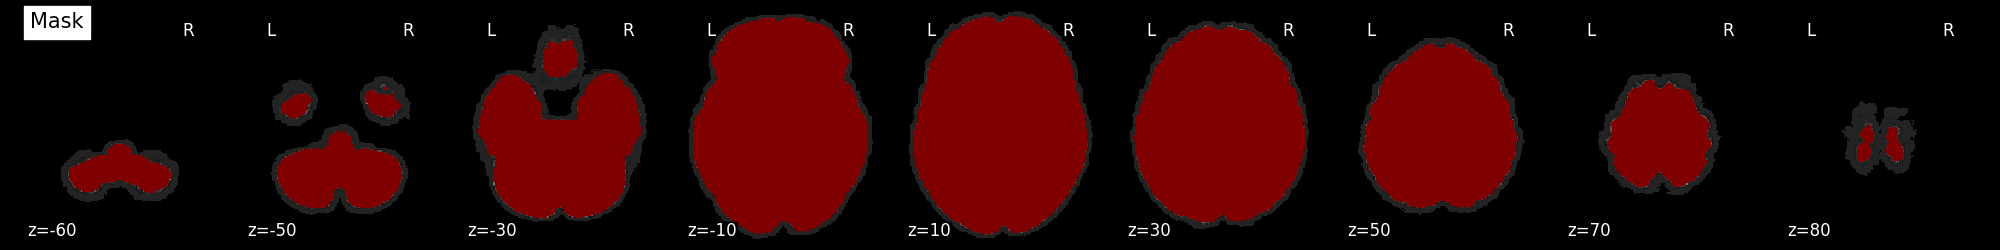

In [51]:
now = datetime.now()
print('Making a mask for analysis:',now.strftime("%H:%M:%S"))
# -------------------
import pandas as pd
import numpy as np
from nilearn.image import new_img_like, load_img
from nilearn.plotting import plot_stat_map, plot_img, show
from nilearn import decoding
from nilearn.decoding import SearchLight
from sklearn import naive_bayes, model_selection #import GaussianNB

#########################################################################
#Make a mask with the whole brain

mask_wb_filename='/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0117/anat/sub-0117_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
anat_filename='/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0117/anat/sub-0117_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'
#Load the whole brain mask
mask_img = load_img(mask_wb_filename)

## This bit can be used if you want to make a smaller select of the brain to study (e.g. to speed up analsysis)
# .astype() makes a copy.
process_mask = mask_img.get_fdata().astype(int)
#Set slices below x in the z-dimension to zero (in voxel space)
process_mask[..., :10] = 0
#Set slices above x in the z-dimension to zero (in voxel space)
process_mask[..., 170:] = 0
process_mask_img = new_img_like(mask_img, process_mask)


#Plot the mask on an anatomical background
plot_img(process_mask_img, bg_img=anat_filename,#bg_img=mean_fmri,
         title="Mask", display_mode="z",cut_coords=[-60,-50,-30,-10,10,30,50,70,80],
         vmin=.40, cmap='jet', threshold=0.9, black_bg=True)


## Run the searchlight analysis

Note. This takes many hours for one participant. I strongly recommond running this in tmux (see notebook folder for info).

In [52]:
now = datetime.now()
print('Starting searchlight analysis:',now.strftime("%H:%M:%S"))
#n_jobs=-1 means that all CPUs will be used

from nilearn.decoding import SearchLight
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

# The radius is the one of the Searchlight sphere that will scan the volume
searchlight = SearchLight(
    mask_img,
    estimator=GaussianNB(),
    process_mask_img=process_mask_img,
    radius=5, n_jobs=-1,
    verbose=10, cv=10)
searchlight.fit(fmri_img_train, conditions_train)

now = datetime.now()
print('Finishing searchlight analysis:',now.strftime("%H:%M:%S"))

Starting searchlight analysis: 21:09:52


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed: 101.0min remaining: 303.1min
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed: 101.3min remaining: 168.9min
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed: 102.0min remaining: 102.0min
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed: 104.4min remaining: 62.7min
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed: 104.5min remaining: 34.8min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed: 105.4min finished


Finishing searchlight analysis: 01:39:31


## Save/restore the variables

In [53]:
import pickle
import nilearn

#Save the searchlight model

# Saving the objects:
f = open('/work/807746/marcs_folder/InSpe_first_level_models_all_trials_searchlight.pkl', 'wb')
pickle.dump([searchlight, searchlight.scores_], f)
f.close()

# Getting back the objects:
#f = open('/work/807746/marcs_folder/InSpe_first_level_models_all_trials_searchlight.pkl', 'rb')
#searchlight,searchlight_scores_ = pickle.load(f)
#f.close()


# Getting back the objects:
#f = open('/work/807746/marcs_folder/InSpe_first_level_models_all_trials_searchlight.pkl', 'rb')
#fmri_img_train, fmri_img_test, idx_train,idx_test, conditions_train,  conditions_test= pickle.load(f)
#f.close()

# Getting back the objects:
#f = open('/work/807746/marcs_folder/InSpe_first_level_models_all_trials_searchlight.pkl', 'rb')
#searchlight,searchlight_scores_ = pickle.load(f)
#f.close()


now = datetime.now()
print('Searchlight output saved:',now.strftime("%H:%M:%S"))


Searchlight output saved: 11:20:20


## Plot the outcome of the searchlight analysis

Plotting and saving searchlight output (threshold:0.6): 11:25:00


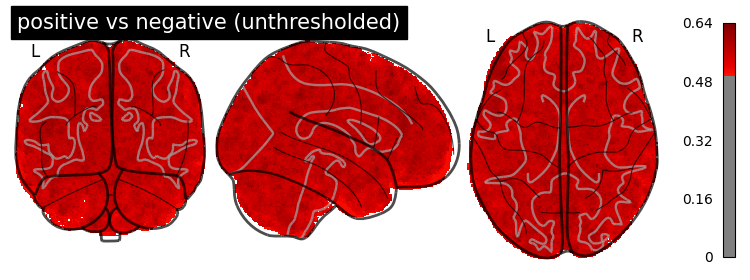

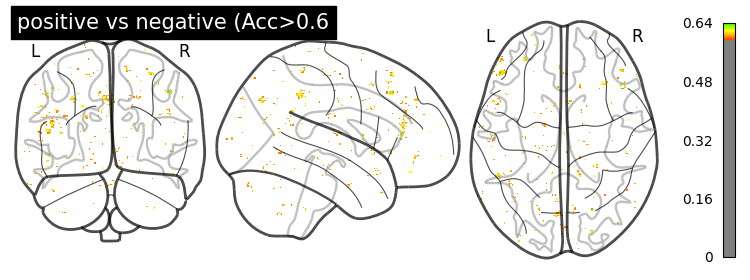

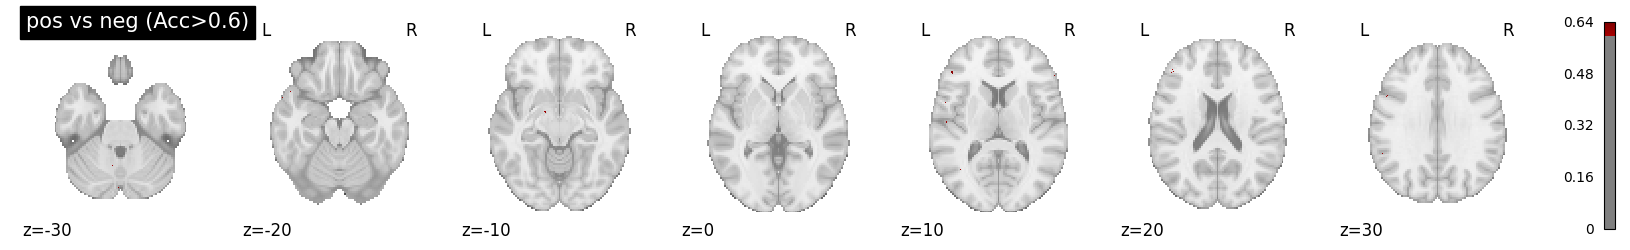

In [55]:
from nilearn import image, plotting
from nilearn.plotting import plot_glass_brain, plot_stat_map
from nilearn.image import new_img_like, load_img
mask_wb_filename='/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0117/anat/sub-0117_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-brain_mask.nii.gz'
anat_filename='/work/816119/InSpePosNegData/BIDS_2023E/derivatives/sub-0117/anat/sub-0117_acq-T1sequence_run-1_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz'

now = datetime.now()
print('Plotting and saving searchlight output (threshold:0.6):',now.strftime("%H:%M:%S"))

#Create an image of the searchlight scores
searchlight_img = new_img_like(anat_filename, searchlight.scores_)


plot_glass_brain(searchlight_img, cmap='jet',colorbar=True, threshold=0.5,
                          title='positive vs negative (unthresholded)',
                          plot_abs=False)

fig=plotting.plot_glass_brain(searchlight_img,cmap='prism',colorbar=True,threshold=0.60,title='positive vs negative (Acc>0.6')
fig.savefig("/work/807746/marcs_folder/InSpe_neg_vs_but_searchlightNB_glass.png", dpi=300)
#plt.show()

plot_stat_map(searchlight_img, cmap='jet',threshold=0.6, cut_coords=[-30,-20,-10,0,10,20,30],
              display_mode='z',  black_bg=False,
              title='pos vs neg (Acc>0.6)')
plt.show()

### Find the 500 most predictive voxels 

In [56]:
print('Number of voxels in searchlight: ',searchlight.scores_.size)
#Find the percentile that makes the cutoff for the 500 best voxels
perc=100*(1-500.0/searchlight.scores_.size)
#Print percentile
print('Percentile for 500 most predictive voxels: ',perc)
#Find the cutoff
cut=np.percentile(searchlight.scores_,perc)
#Print cutoff
print('Cutoff for 500 most predictive voxels: ', cut)
#cut=0
#Make a mask using cutoff

#Load the whole brain mask
mask_img2 = load_img(mask_wb_filename)

# .astype() makes a copy.
process_mask2 = mask_img2.get_fdata().astype(int)
process_mask2[searchlight.scores_<=cut] = 0
process_mask2_img = new_img_like(mask_img2, process_mask2)



Number of voxels in searchlight:  8980290
Percentile for 500 most predictive voxels:  99.9944322510743
Cutoff for 500 most predictive voxels:  0.5977832512315271


/tmp/ipykernel_818/642982622.py:19: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  process_mask2_img = new_img_like(mask_img2, process_mask2)


### Visualization of the voxels

/work/807746/marcs_folder/notebooks/virt_env/lib/python3.10/site-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


Saving glass brain with 500 most predictive voxels: 11:28:10


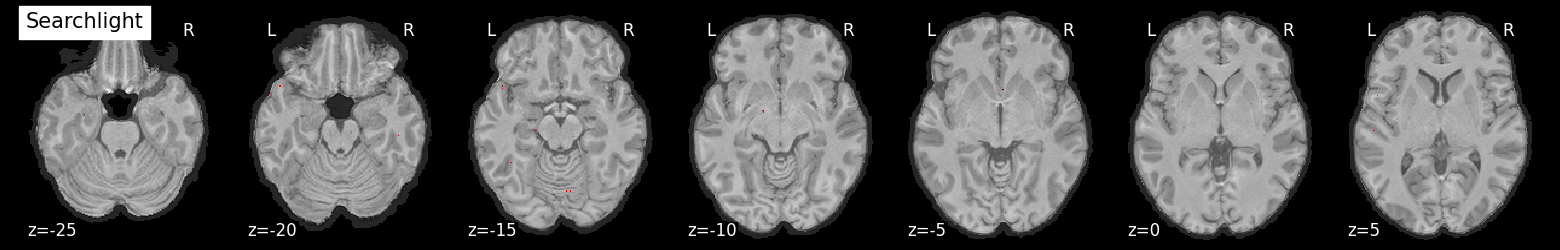

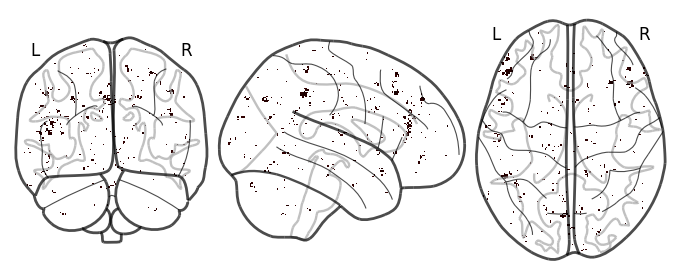

In [57]:
# --------------
from nilearn import image
from nilearn.plotting import plot_stat_map, plot_img, show
from nilearn import plotting
%matplotlib inline
#Create an image of the searchlight scores
searchlight_img = new_img_like(anat_filename, searchlight.scores_)
#Plot the searchlight scores on an anatomical background
plot_img(searchlight_img, bg_img=anat_filename,#bg_img=mean_fmri,
         title="Searchlight", display_mode="z",cut_coords=[-25,-20,-15,-10,-5,0,5],
         vmin=.40, cmap='jet', threshold=cut, black_bg=True)
#plotting.plot_glass_brain effects
fig=plotting.plot_glass_brain(searchlight_img,threshold=cut)
fig.savefig("/work/807746/marcs_folder/InSpe_neg_vs_but_searchlightNB_glass_500.png", dpi=300)

now = datetime.now()
print('Saving glass brain with 500 most predictive voxels:',now.strftime("%H:%M:%S"))

In [58]:
from atlasreader import create_output
create_output(searchlight_img, voxel_thresh=cut, cluster_extent=2,direction='pos')
#Atlasreader automatically saves results to both .png-files and a csv-file. Look in your working directory.
pd.read_csv('atlasreader_peaks.csv')

The Python package you are importing, AtlasReader, is licensed under the
BSD-3 license; however, the atlases it uses are separately licensed under more
restrictive frameworks.
By using AtlasReader, you agree to abide by the license terms of the
individual atlases. Information on these terms can be found online at:
https://github.com/miykael/atlasreader/tree/master/atlasreader/data



,cluster_id,peak_x,peak_y,peak_z,peak_value,volume_mm,aal,desikan_killiany,harvard_oxford
0,1.0,-49.0,-44.070,41.194,0.624754,29.590399,Parietal_Inf_L,Left-Cerebral-White-Matter,30.0% Left_Supramarginal_Gyrus_posterior_divis...
1,2.0,44.0,25.297,42.171,0.635961,23.863225,Frontal_Mid_2_R,Unknown,74.0% Right_Middle_Frontal_Gyrus
2,3.0,-47.0,35.067,9.930,0.624877,13.363406,Frontal_Inf_Tri_L,Unknown,48.0% Left_Inferior_Frontal_Gyrus_pars_triangu...
3,4.0,31.0,26.274,56.826,0.621305,11.454348,Frontal_Sup_2_R,Unknown,37.0% Right_Middle_Frontal_Gyrus; 12.0% Right_...
4,5.0,-3.0,-72.403,36.309,0.614409,11.454348,Precuneus_L,ctx-lh-precuneus,62.0% Left_Precuneous_Cortex; 14.0% Left_Cunea...
...,...,...,...,...,...,...,...,...,...
60,61.0,12.0,-16.714,58.780,0.604557,1.909058,Supp_Motor_Area_R,Right-Cerebral-White-Matter,12.0% Right_Precentral_Gyrus
61,62.0,-48.0,34.090,12.861,0.617734,1.909058,Frontal_Inf_Tri_L,Unknown,50.0% Left_Inferior_Frontal_Gyrus_pars_triangu...
62,63.0,-49.0,36.044,13.838,0.617857,1.909058,Frontal_Inf_Tri_L,Unknown,35.0% Left_Inferior_Frontal_Gyrus_pars_triangu...
63,64.0,-50.0,34.090,17.746,0.611084,1.909058,Frontal_Inf_Tri_L,ctx-lh-parsopercularis,35.0% Left_Middle_Frontal_Gyrus; 27.0% Left_In...


### Make a permutation classification test on the 2nd data split using the best voxels

In [10]:
now = datetime.now()
print('Perform permutation test on test set using 500 predictive voxels:',now.strftime("%H:%M:%S"))
from sklearn.naive_bayes import GaussianNB
from nilearn.input_data import NiftiMasker
masker = NiftiMasker(mask_img=process_mask2_img, standardize=False)

# We use masker to retrieve a 2D array ready
# for machine learning with scikit-learn
fmri_masked = masker.fit_transform(fmri_img_test)
#Print size of matrix (images x voxels)
print(fmri_masked.shape)

from sklearn.model_selection import permutation_test_score
score_cv_test, scores_perm, pvalue= permutation_test_score(
    GaussianNB(), fmri_masked, conditions_test, cv=10, n_permutations=1000, 
    n_jobs=-1, random_state=0, verbose=0, scoring=None)
print("Classification Accuracy: %s (pvalue : %s)" % (score_cv_test, pvalue))



Perform permutation test on test set using 500 predictive voxels: 18:50:24


/work/807746/marcs_folder/notebooks/virt_env/lib/python3.10/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


NameError: name 'process_mask2_img' is not defined

## Saving permutation outcomes

In [60]:
import pickle

now = datetime.now()
print('Saving permutation scores:',now.strftime("%H:%M:%S"))
#Save the permutation scores

# Saving the objects:
f = open('/work/807746/marcs_folder/InSpe_first_level_models_all_trials_searchlight_perms.pkl', 'wb')
pickle.dump([score_cv_test, scores_perm, pvalue], f)
f.close()

# Getting back the objects:
#f = open('/work/MikkelWallentin#6287/InSpe_first_level_models_all_trials_searchlight_perms.pkl', 'rb')
#score_cv_test, scores_perm, pvalue = pickle.load(f)
#f.close()



Saving permutation scores: 14:01:42


### View a histogram of permutation scores

In [3]:
now = datetime.now()
print('Plotting and saving permutation scores:',now.strftime("%H:%M:%S"))

import numpy as np
import matplotlib.pyplot as plt
#How many classes
n_classes = np.unique(conditions_test).size

plt.hist(scores_perm, 20, label='Permutation scores',
         edgecolor='black')
ylim = plt.ylim()
plt.plot(2 * [score_cv_test], ylim, '--g', linewidth=3,
         label='Classification Score'
         ' (pvalue %s)' % pvalue)
plt.plot(2 * [1. / n_classes], ylim, '--k', linewidth=3, label='Chance level')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')

plt.savefig("/work/807746/marcs_folder/InSpe_neg_vs_pos_one_sub_perm.png", dpi=300)
plt.show()

Plotting and saving permutation scores: 16:12:16


NameError: name 'conditions_test' is not defined

[NbConvertApp] Converting notebook /work/857248/16_Nilearn_InSpe_classification_single_sub.ipynb to python
[NbConvertApp] Writing 18672 bytes to /work/857248/16_Nilearn_InSpe_classification_single_sub.py
